In [1]:
from fastai.vision.all import *
from fastai.distributed import *
from fastai.vision.gan import *
from fastai.callback.tracker import SaveModelCallback
from fastai import torch_core

from fastprogress import fastprogress
import torch
import argparse
from models.utils.gan_joiner import GAN
from models.utils.losses import *
from models.utils.metrics import *
from models.utils.misc import *
from models.unet import UNet
from models.utils.datasets import *

from torchvision import datasets, transforms, models
import torchvision.transforms as T

In [2]:
H = 320
W= 320
bs = 5
nclass = 10
#seed = 1234
#torch.manual_seed(seed)
#torch.cuda.manual_seed(seed)

In [3]:
#path = './data/ImageNetRotation1k/'
path = untar_data(URLs.IMAGENETTE_320)

transform = ([*aug_transforms(),Normalize.from_stats([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

data = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                 get_items=get_image_files, 
                 splitter=RandomSplitter(),
                 get_y=parent_label,
                 item_tfms=Resize(H,W),
                 batch_tfms=transform)

dloader = data.dataloaders(path,bs=bs) 

In [4]:
GanLoss = GanLossWrapper(beta=0.000000, gamma=0.005,sigma=1)

gan = GAN(num_encoder_layers = 4, nhead=4, backbone = True, num_classes = nclass, bypass=False, hidden_dim=256, 
          batch_size=bs, image_h=H, image_w=W,grid_l=4,penalty_factor="2")

In [5]:
gan.generatorSwitcher()
gan.noiseSwitcher()
print("Noise mode:", gan.noise_mode)
print("Generator mode:", gan.generator_mode)
gan.paramsToUpdate()
gan.assertParams()

Noise mode: False
Generator mode: False


In [5]:
@patch
def load(self:Learner, file, with_opt=None, device=None, **kwargs):
    print("Model load")
    if device is None and hasattr(self.dls, 'device'): device = self.dls.device
    if with_opt is None: self.opt=None
    #file = join_path_file(file, self.path/self.model_dir, ext='.pth')
    #load_model(file, self.model, self.opt, device=device, **kwargs)
    return self
#Learner.load = alt_load

In [6]:
learner = Learner(dloader, gan, loss_func=GanLoss, splitter=trainable_params, 
                  metrics=[Reconstruction_Loss, Accuracy])

In [7]:
critic_learner = Learner(dloader, gan, loss_func=GanLoss, metrics=[Reconstruction_Loss, Accuracy])
generator_learner = Learner(dloader, gan, loss_func=GanLoss, metrics=[Reconstruction_Loss, Accuracy])

In [13]:
critic_learner.model.generatorSwitcher()
critic_learner.model.noiseSwitcher()
critic_learner.model.paramsToUpdate()

In [8]:
print("Critic Noise mode:", critic_learner.model.noise_mode)
print("Critic Gen mode:", critic_learner.model.generator_mode)
print("Generator Noise mode:", generator_learner.model.noise_mode)
print("Generator Gen mode:", generator_learner.model.generator_mode)

Critic Noise mode: True
Critic Gen mode: True
Generator Noise mode: True
Generator Gen mode: True


In [9]:
assert critic_learner.model == generator_learner.model

In [7]:
assert learner.model == gan

Noise mode: False
Generator mode: False


Model load


SuggestedLRs(lr_min=1.0964781722577755e-07, lr_steep=7.585775847473997e-07)

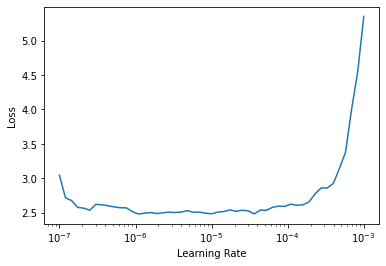

In [10]:
print("Noise mode:", critic_learner.model.noise_mode)
print("Generator mode:", critic_learner.model.generator_mode)
critic_learner.lr_find()

Noise mode: True
Generator mode: True


Model load


SuggestedLRs(lr_min=0.02089296132326126, lr_steep=9.12010818865383e-07)

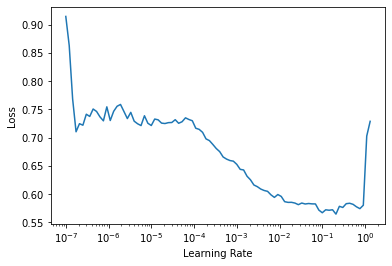

In [11]:
generator_learner.model.generatorSwitcher()
generator_learner.model.noiseSwitcher()
generator_learner.model.paramsToUpdate()
print("Noise mode:", generator_learner.model.noise_mode)
print("Generator mode:", generator_learner.model.generator_mode)
generator_learner.model.assertParams()
generator_learner.lr_find()

In [8]:
print("Noise mode:", learner.model.noise_mode)
print("Generator mode:", learner.model.generator_mode)

Noise mode: True
Generator mode: True


In [9]:
epochs = 3
for e in range(epochs):
    
    print("Epoch", e+1)
    print("Generator training")
    assert learner.model == gan
    #Generator Training
    print("Noise mode:", learner.model.noise_mode)
    print("Generator mode:", learner.model.generator_mode)
    gan.paramsToUpdate()
    gan.assertParams()
    
    learner.fit_one_cycle(1,0.001)
    
    print("Critit training without noised images")
    assert learner.model == gan
    gan.generatorSwitcher()
    gan.noiseSwitcher()
    gan.paramsToUpdate()
    gan.assertParams()
    print("Noise mode:", learner.model.noise_mode)
    print("Generator mode:", learner.model.generator_mode)
    
    learner.fit_one_cycle(1,2e-6)
    
    print("Critit training with noised images")
    assert learner.model == gan
    #Critit training with noised images
    gan.noiseSwitcher()
    gan.assertParams()
    print("Noise mode:", learner.model.noise_mode)
    print("Generator mode:", learner.model.generator_mode)
    
    learner.fit_one_cycle(1,2e-6)
    gan.generatorSwitcher()

Epoch 1
Generator training
Noise mode: True
Generator mode: True


epoch,train_loss,valid_loss,Reconstruction_Loss,Accuracy,time
0,0.012597,0.012379,0.000142,0.119119,10:04


Critit training without noised images
Noise mode: False
Generator mode: False


epoch,train_loss,valid_loss,Reconstruction_Loss,Accuracy,time
0,2.462358,2.452393,0.000000,0.110904,04:24


Critit training with noised images
Noise mode: True
Generator mode: False


epoch,train_loss,valid_loss,Reconstruction_Loss,Accuracy,time
0,2.502080,2.445383,0.000000,0.116878,06:48


Epoch 2
Generator training
Noise mode: True
Generator mode: True


epoch,train_loss,valid_loss,Reconstruction_Loss,Accuracy,time
0,0.012469,0.012373,0.000143,0.119866,10:02


Critit training without noised images
Noise mode: False
Generator mode: False


epoch,train_loss,valid_loss,Reconstruction_Loss,Accuracy,time
0,2.436006,2.454237,0.000000,0.111650,04:30


Critit training with noised images
Noise mode: True
Generator mode: False


epoch,train_loss,valid_loss,Reconstruction_Loss,Accuracy,time
0,2.425931,2.444215,0.000000,0.115011,06:48


Epoch 3
Generator training
Noise mode: True
Generator mode: True


epoch,train_loss,valid_loss,Reconstruction_Loss,Accuracy,time
0,0.012334,0.012290,0.000053,0.120239,09:59


Critit training without noised images
Noise mode: False
Generator mode: False


epoch,train_loss,valid_loss,Reconstruction_Loss,Accuracy,time


KeyboardInterrupt: 

In [10]:
epochs = 3
for e in range(epochs):
    
    print("Epoch", e+1)
    print("Generator training")
    assert critic_learner.model == generator_learner.model
    #Generator Training
    print("Noise mode:", generator_learner.model.noise_mode)
    print("Generator mode:", generator_learner.model.generator_mode)
    gan.paramsToUpdate()
    gan.assertParams()
    
    generator_learner.fit_one_cycle(1,0.001)
    
    print("Critit training without noised images")
    assert critic_learner.model == generator_learner.model
    gan.generatorSwitcher()
    gan.noiseSwitcher()
    gan.paramsToUpdate()
    gan.assertParams()
    print("Noise mode:", critic_learner.model.noise_mode)
    print("Generator mode:", critic_learner.model.generator_mode)
    
    critic_learner.fit_one_cycle(1,2e-6)
    
    print("Critit training with noised images")
    assert critic_learner.model == generator_learner.model
    #Critit training with noised images
    gan.noiseSwitcher()
    gan.assertParams()
    print("Noise mode:", critic_learner.model.noise_mode)
    print("Generator mode:", critic_learner.model.generator_mode)
    critic_learner.fit_one_cycle(1,2e-6)
    gan.generatorSwitcher()

Epoch 1
Generator training
Noise mode: True
Generator mode: True


epoch,train_loss,valid_loss,Reconstruction_Loss,Accuracy,time
0,0.012571,0.012553,0.000285,0.092233,10:03


Critit training without noised images
Noise mode: False
Generator mode: False


epoch,train_loss,valid_loss,Reconstruction_Loss,Accuracy,time
0,2.167741,2.209641,0.000000,0.182599,05:27


Critit training with noised images
Noise mode: True
Generator mode: False


epoch,train_loss,valid_loss,Reconstruction_Loss,Accuracy,time
0,2.174106,2.172366,0.000000,0.222181,07:47


ModuleAttributeError: 'Joiner' object has no attribute 'generatorSwitcher'

In [11]:
critic_learner.model.model.encoder.encoder.layers[3].self_attn.out_proj.weight == generator_learner.model.model.encoder.encoder.layers[3].self_attn.out_proj.weight

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]], device='cuda:0')